In [1]:
import torch 
import numpy as np

from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler

from data.budworm import simulate_trials, budworm_steady_states
from stabnode.utils import set_global_seed
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('ggplot')


seed = 1234
set_global_seed(seed=seed)


device='cpu'
savefigs = False
folder = "figures_g_sigmoid/"

In [2]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)
print(r1,r2)

k1 = r1-1.1
k2 = r2+1.1

def smooth_k(t):
    A = (k2-k1)/2
    return A*np.sin(t-np.pi/2)+A + k1

def smooth_k_torch(t):
    A = (k2-k1)/2
    return A*torch.sin(t-torch.pi/2) + A + k1

6.44569072482332 9.93441120446710


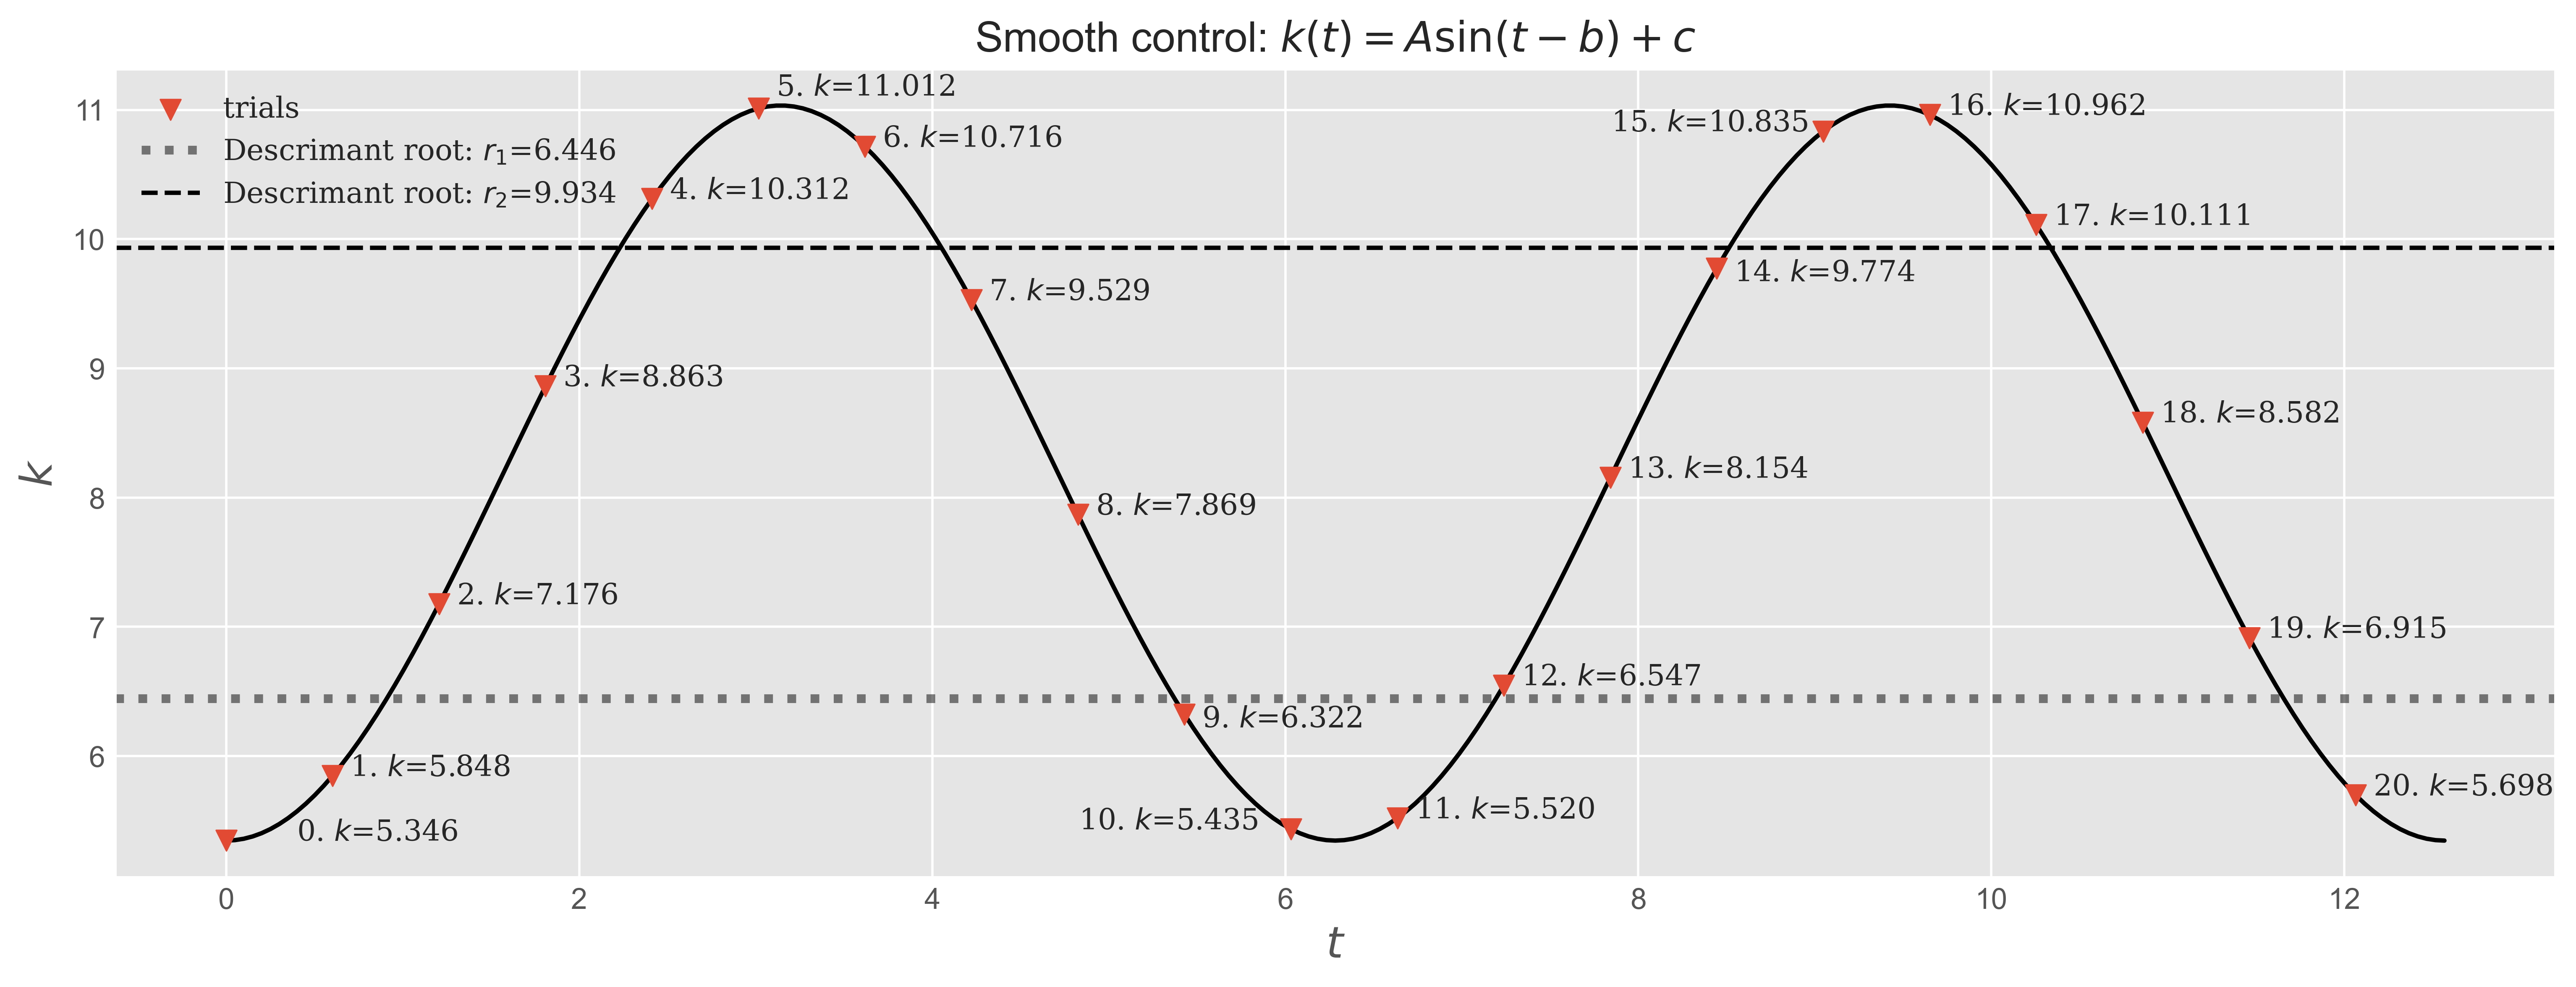

In [3]:
sample_rate = 12
t_span = np.linspace(0,4*np.pi,251)
t_trials = t_span[::sample_rate]
k_true = smooth_k(t_span)
k_trials = smooth_k(t_trials)


fig, ax = plt.subplots(1,1,figsize=(15,5),dpi=500)
t_span = np.linspace(0,4*np.pi,251)

ax.plot(t_span, k_true,c='black',zorder=1)
ax.scatter(
    t_span[::sample_rate],
    k_trials,
    label='trials',
    marker='v',
    s=50,
    zorder=2
)

for idx, (x,y) in enumerate(zip(t_span[::sample_rate],k_trials)):
    x_buff = 0.1
    if idx == 10 or idx == 15:
        x_buff = -1.2
    if idx == 0:
        x_buff = 0.4

    y_buff = 0
    if idx == 9 or idx == 14:
        y_buff = -0.1
    
    if idx == 5:
        y_buff = 0.1
    ax.text(x+x_buff,y+y_buff,s=rf'{idx}. $k$={y:.3f} ',family='serif',zorder=3)

ax.grid(True)
ax.axhline(r1,linestyle=':',c='black', alpha=0.5,label=rf"Descrimant root: $r_1$={r1:.3f}",lw=3,zorder=1)
ax.axhline(r2, linestyle='--',c='black', label=rf"Descrimant root: $r_2$={r2:.3f}",zorder=1)
ax.set_ylabel(r"$k$", size=15)
ax.set_xlabel(r"$t$",size=15)
ax.set_title(r"Smooth control: $k(t) = A\sin(t-b)+c$")
ax.legend(prop={'family':'serif'})
if savefigs:
    plt.savefig(folder+f"budworm_smooth_control_{len(k_trials)}_k_trials.pdf")
plt.grid(True)
plt.show()

In [4]:
k_vals = [5.5, 8.5,11,7.5,6.3]
xs = np.linspace(0.1, 10, 51)

In [5]:
trials = {}


for idx, ki in enumerate(tqdm(k_vals)):

    ki_traj = []
    ki_times= []
    
    for x0 in tqdm(xs):
        trial_ki = simulate_trials([ki],x0,dt=0.2,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501,show_progress=False)
        ti = trial_ki.t_vals[0]
        xi = trial_ki.x_vals[0]

        if len(ti) == 1:
            continue
        ki_traj.append(xi)
        ki_times.append(ti)

    trials[f"{idx}"] = {
        "traj": ki_traj,
        "times": ki_times,
        "k": ki, 
        "trial": idx
    }

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [6]:
len(trials["3"]["traj"])

50

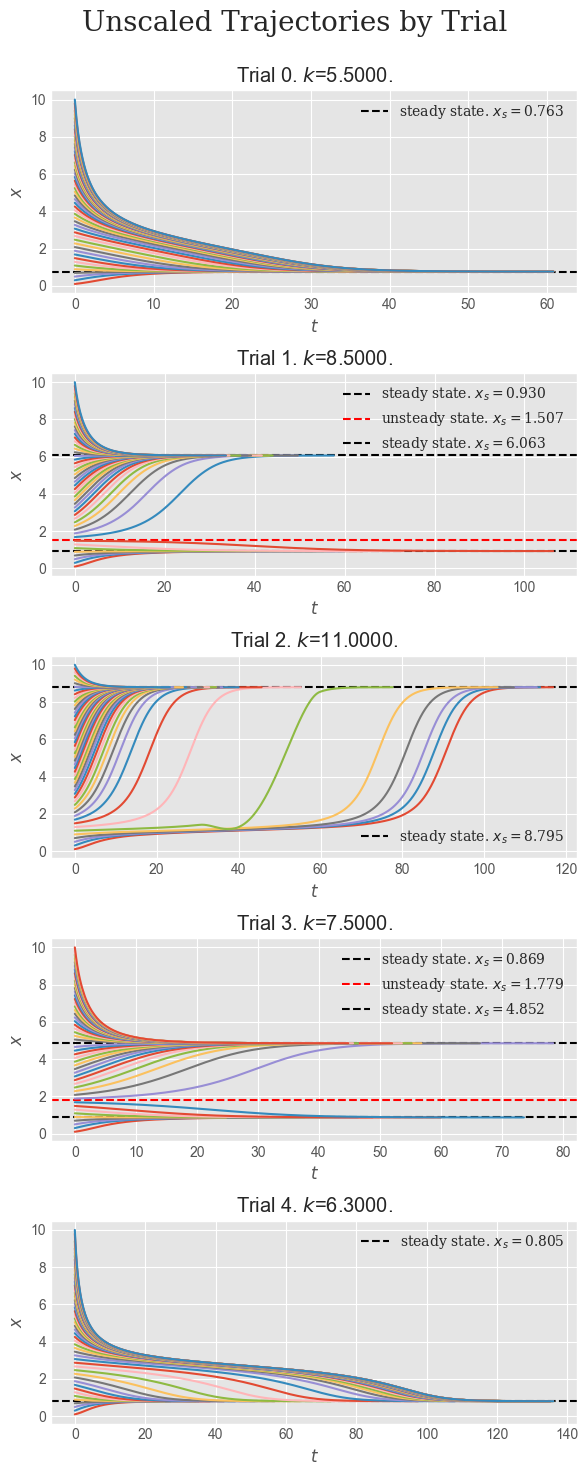

In [7]:
cols = 1
rows = len(trials)

fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 3*rows))

axs = axs.flatten()

for idx in range(rows):
    ax = axs[idx]
    trial_i = trials[f"{idx}"]

    times = trial_i["times"]
    traj = trial_i["traj"]
    ki = trial_i["k"]

    for ti, xi in zip(times, traj):
        ax.plot(ti,xi)

    for idx2,xsi in enumerate(budworm_steady_states(ki,r=0.56)):
        label = rf"steady state. $x_s=${xsi:.3f}"
        color = 'black'
        if idx2 ==1:
            label = rf"unsteady state. $x_s=${xsi:.3f}"
            color = 'red'

        ax.axhline(
            xsi,
            xmin=0,
            c=color,
            linestyle="--",
            label=label,
            zorder=1
        )
    
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$x$")
    ax.set_title(rf"Trial {idx}. $k$={ki:.4f}.")
    ax.legend(prop={'family':'serif'})




plt.suptitle("Unscaled Trajectories by Trial", family='serif',size=20)
plt.tight_layout(rect=[0,0,1,0.98])

if savefigs:
    file_name = f"unscaled_trajectories_num_k_{len(k_trials)}_num_x0_{len(xs)}.pdf"
    plt.savefig(folder+file_name)

plt.show()    


## Preprocess data

In [8]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [9]:
trial_df = pd.DataFrame(trials)

In [10]:
full_traj = []
for col in trial_df.columns:
    full_traj.append(np.concatenate(trial_df[col].traj))

In [11]:
scaler = MinMaxScaler()
scaler.fit(np.concatenate(full_traj).reshape(-1,1))

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [12]:
scaled_rows = {}
for col in trial_df.columns:
    traj = trial_df[col].traj
    scaled_traj = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in traj]
    scaled_rows[col] = scaled_traj

trial_df.loc["scaled_traj"] = pd.Series(scaled_rows)

In [13]:
all_xs = []
all_ts = []
all_ks = []

for trial_i in trial_df.columns:
    xs_scaled = trial_df[trial_i].scaled_traj
    ts = trial_df[trial_i].times
    k = trial_df[trial_i].k

    xs_torch = [torch.tensor(xi, dtype=torch.float32, device=device) for xi in xs_scaled]
    ts_torch = [torch.tensor(ti, dtype=torch.float32, device=device) for ti in ts]
    ks = [torch.tensor(k, dtype=torch.float32, device=device) for _ in range(len(ts))]

    all_xs.extend(xs_torch)
    all_ts.extend(ts_torch)
    all_ks.extend(ks)


In [14]:
from typing import List

class TrialsDataset(torch.utils.data.Dataset):
    def __init__(self, x_trials:List, t_trials:List, k_trials: List):
        self.x_trials = x_trials            
        self.t_trials = t_trials    
        self.k_trials = k_trials          

    def __len__(self):
        return len(self.x_trials) 

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.__len__():
            raise IndexError(
                f"Index {idx} is out of bounds of dataset size: {self.__len__()}."
            )
        
        
        Xi = self.x_trials[idx]                                          
        ti = self.t_trials[idx]  
        x0 = Xi[0]           
        ki = self.k_trials[idx]

        return Xi,ti,x0, ki

In [15]:
cutoff = 1
train_dataset = TrialsDataset(all_xs[::cutoff],all_ts[::cutoff],all_ks[::cutoff])
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=1,num_workers=0)

In [16]:
len(train_loader)

254

In [17]:
# idx = 0
# for out in train_loader:
#     *_, ki = out
#     print(ki)

In [18]:
# xi.shape,ti.shape, x0i.shape,ki.shape

## $\tilde g$ and $\tilde f$ bounds

In [19]:
from data.budworm import g_true, f_true

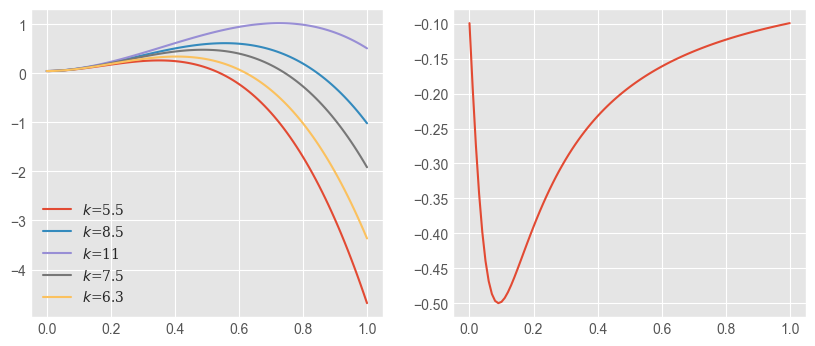

(1.0227762788018373, -4.684481175390267)

In [20]:
x_lin = np.linspace(0,1,101)
x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).squeeze()

fig , (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
maxs = []
mins = []
for k in k_vals:
    g_true_arr = scaler.transform(g_true(x_lin_unscaled,k,r=0.56).reshape(-1,1)).reshape(-1)
    maxs.append(g_true_arr.max())
    mins.append(g_true_arr.min())

    ax1.plot(x_lin, g_true_arr, label=rf"$k$={k}")

ax1.legend(prop={'family':'serif'})

f_true_arr = f_true(x_lin_unscaled)
ax2.plot(x_lin, f_true_arr)
plt.show()

max(maxs), min(mins)

## New model trainer

In [21]:
from stabnode.node import GeluSigmoid, FeluSigmoid, StabNODE, model_trainer, FeluSigmoidMLP, GeluSigmoidMLP, GeluSigmoidMLPfeaturized,FeluSigmoidMLPfeaturized
import torch.nn as nn

In [22]:
f = FeluSigmoidMLP(
    dims = [1,10,10,1],
    activation = torch.nn.SiLU(), 
    lower_bound = -0.5, 
    upper_bound = -0.1,)

#g = GeluSigmoidMLP(dims = [2,10,10,1], activation = torch.nn.SiLU(), lower_bound = -10, upper_bound = 10
#)

g = GeluSigmoidMLPfeaturized(
    dims = [6,10,10,1], 
    activation = torch.nn.SiLU(), 
    lower_bound = -5, 
    upper_bound = 1.1, 
    freq_sample_step = 1,
    feat_lower_bound=0,
    feat_upper_bound=1
    )


model = StabNODE(f,g).to(device)

In [23]:
n_epochs = 1000
lr = 1e-2
show_progress = True
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',factor=0.1,patience=10)

model, log_history = model_trainer(
    model=model,
    opt=opt,
    loss_criteria=loss_criteria,
    train_loader=train_loader,
    n_epochs=n_epochs,
    control=None,
    min_improvement=1e-6,
    patience=300,
    solve_method='tsit5',
    save_folder=None,
    show_progress=True,
    scheduler=scheduler,
    print_every=10,
    _precision=10,
    train_dyn = True,
    decay_scheduler=None,
    decay_val=0.8
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss: 0.0035313244. time = 230.7969417572s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 1: Loss: 0.0004580688. time = 198.2210166454s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 2: Loss: 0.0001591693. time = 182.8879518509s. lr = 0.0100000000. alpha = 0.8000000000
Epoch 3: Loss: 0.0001462698. time = 187.2647109032s. lr = 0.0100000000. alpha = 0.8000000000


KeyboardInterrupt: 

In [ ]:
for xi, ti, x0i, ki in train_loader:
    ti = ti.squeeze()
    if ti.ndim==0:
        print(x0i)
        print(ki)


In [ ]:
idx = 0 
for traj in trial_df['3'].traj:
    if len(traj) == 1:
        print(idx)
    idx +=1

In [ ]:
trial_df['3'].traj[24]

In [ ]:
idx = 0
for time in trial_df["3"].times:
    if len(time) == 1:
        print(idx)
    idx+=1

In [ ]:
trial_df["3"].times[24]

In [ ]:
from data.budworm import budworm_steady_states

In [ ]:
scaler.transform(np.array(budworm_steady_states(7.5, 0.56)).reshape(-1,1))